<a href="https://colab.research.google.com/github/andrytumaruk/klasifikasi-gambar-wajah-hewan/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Andry septian syahputra tumaruk
- **Email:** andryg9501@gmail.com
- **ID Dicoding:** mc476d5y0692

# Import Library

In [1]:
import os,shutil
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm as tq
from collections import Counter
import matplotlib.image as mpimg
from matplotlib.image import imread

# libraries untuk pemrosesan data

# libraries tensorflow dan keras
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Activations
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizers
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils

# from keras.utils.vis_utils import model_to_dot
from keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from PIL import Image

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

# Data Prepration

## Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrytumaruk","key":"49c9cd5c2c5d9413fc913b9192a4bb03"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'andrewmvd/animal-faces'
!unzip animal-faces.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train

In [4]:
train_dir= "afhq/train"
val_dir= "afhq/val"

gabung_dir="afhq/dataset"

os.makedirs(gabung_dir,exist_ok=True)

for category in os.listdir(train_dir):
  category_dir=os.path.join(train_dir,category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir,os.path.join(gabung_dir,category),dirs_exist_ok=True)


for category in os.listdir(val_dir):
  category_dir=os.path.join(val_dir,category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir,os.path.join(gabung_dir,category),dirs_exist_ok=True)

print(f"banyak dataset gambar cat : {len(os.listdir(os.path.join(gabung_dir,'cat')))} gambar")
print(f"banyak dataset gambar dog : {len(os.listdir(os.path.join(gabung_dir,'dog')))} gambar")
print(f"banyak dataset gambar wild: {len(os.listdir(os.path.join(gabung_dir,'wild')))} gambar")

banyak dataset gambar cat : 5653 gambar
banyak dataset gambar dog : 5239 gambar
banyak dataset gambar wild: 5238 gambar


# Data Preprocessing

## Split Dataset

In [5]:
import random
from sklearn.model_selection import train_test_split

# Path asal dataset gabungan
gabung_dir = 'afhq/dataset'

# Path baru untuk split dataset
base_dir = 'split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Buat direktori jika belum ada
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Loop untuk tiap kategori (cat, dog, wild)
for category in os.listdir(gabung_dir):
    category_path = os.path.join(gabung_dir, category)
    images = os.listdir(category_path)

    # Acak dan split data
    train_files, temp_files = train_test_split(images, test_size=0.2, random_state=42)  # 80% train
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # 10% val, 10% test

    for split, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
        dest_category_dir = os.path.join(split, category)
        os.makedirs(dest_category_dir, exist_ok=True)
        for fname in files:
            shutil.copy(os.path.join(category_path, fname), os.path.join(dest_category_dir, fname))

print("✅ Dataset berhasil di-split (80% train, 10% val, 10% test):")
print(f"- Train: {sum([len(os.listdir(os.path.join(train_dir, cat))) for cat in os.listdir(train_dir)])} gambar")
print(f"- Validation: {sum([len(os.listdir(os.path.join(val_dir, cat))) for cat in os.listdir(val_dir)])} gambar")
print(f"- Test: {sum([len(os.listdir(os.path.join(test_dir, cat))) for cat in os.listdir(test_dir)])} gambar")

✅ Dataset berhasil di-split (80% train, 10% val, 10% test):
- Train: 12903 gambar
- Validation: 1613 gambar
- Test: 1614 gambar


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi untuk training, normalisasi untuk semuanya
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Direktori
base_dir = 'split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 12903 images belonging to 3 classes.
Found 1613 images belonging to 3 classes.
Found 1614 images belonging to 3 classes.


# Modeling

In [7]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 kelas: cat, dog, wild
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.7130 - loss: 0.6427 - val_accuracy: 0.9355 - val_loss: 0.1594
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9539 - loss: 0.1300 - val_accuracy: 0.9578 - val_loss: 0.1142
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 710s 2s/step - accuracy: 0.9716 - loss: 0.0802 - val_accuracy: 0.9640 - val_loss: 0.1068
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.9815 - loss: 0.0503 - val_accuracy: 0.9541 - val_loss: 0.1206
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.9902 - loss: 0.0303 - val_accuracy: 0.9647 - val_loss: 0.1195
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - accuracy: 0.9926 - loss: 0.0234 - val_accuracy: 0.9647 - val_loss: 0.1125
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.9944 - loss: 0.0151 - val_accuracy: 0.9628 - val_loss: 0.1307
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.9949 - loss: 0.0151 - val_accu

# Evaluasi dan Visualisasi

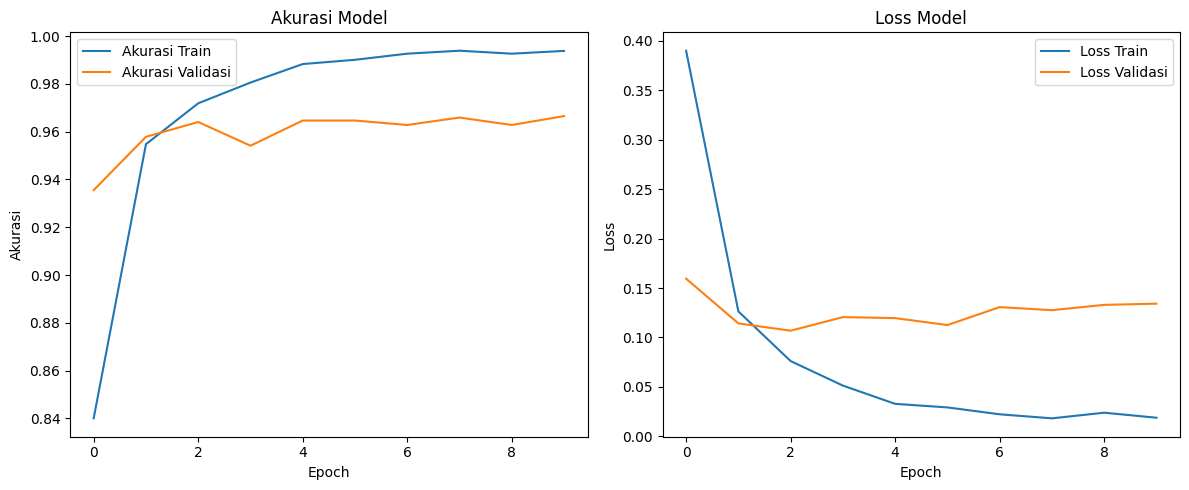

In [12]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Akurasi Train')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()


# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 754ms/step


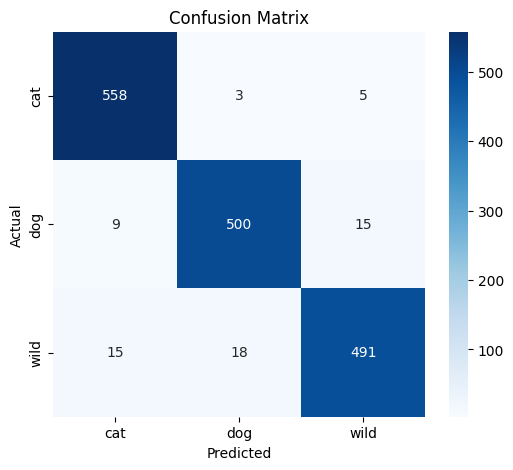

              precision    recall  f1-score   support

         cat       0.96      0.99      0.97       566
         dog       0.96      0.95      0.96       524
        wild       0.96      0.94      0.95       524

    accuracy                           0.96      1614
   macro avg       0.96      0.96      0.96      1614
weighted avg       0.96      0.96      0.96      1614



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
# Prediksi label dari test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Laporan klasifikasi lengkap
print(classification_report(y_true, y_pred, target_names=class_labels))

# Konversi Model

In [40]:
import tensorflowjs as tfjs
# Direktori output
saved_model_dir = "saved_model"
tflite_dir = "tflite"
tfjs_dir = "tfjs_model"

os.makedirs(saved_model_dir, exist_ok=True)
os.makedirs(tflite_dir, exist_ok=True)
os.makedirs(tfjs_dir, exist_ok=True)

# Simpan model ke format SavedModel
model.export(saved_model_dir)

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TFLite
with open(os.path.join(tflite_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

# Simpan label
with open(os.path.join(tflite_dir, "label.txt"), "w") as f:
    f.write("\n".join(["cat", "dog", "wild"]))

# Konversi ke format TensorFlow.js
tfjs.converters.convert_tf_saved_model(saved_model_dir, tfjs_dir)

print("Model berhasil disimpan ke dalam format: SavedModel, TFLite, dan TensorFlow.js.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138153418392208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153418391824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416542544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416542928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416541968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416541008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153418391632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416541776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416544080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138153416545040: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil disimp

# Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


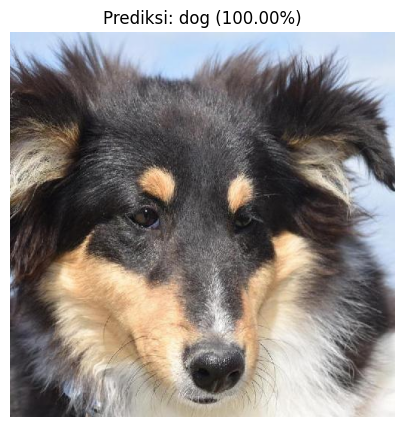

Probabilitas per kelas:
cat: 0.00%
dog: 100.00%
wild: 0.00%


In [24]:
from tensorflow.keras.preprocessing import image
import cv2
def predict_and_show(img_path, model, class_labels):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)[0]
    predicted_index = np.argmax(prediction)
    predicted_label = class_labels[predicted_index]
    confidence = prediction[predicted_index]

    # Tampilkan gambar dan hasil prediksi
    plt.figure(figsize=(5,5))
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label} ({confidence*100:.2f}%)")
    plt.show()

    # Tampilkan semua probabilitas
    print("Probabilitas per kelas:")
    for i, label in enumerate(class_labels):
        print(f"{label}: {prediction[i]*100:.2f}%")

# Contoh penggunaan:
class_labels = list(train_generator.class_indices.keys())
predict_and_show("split_data/test/dog/pixabay_dog_000182.jpg", model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


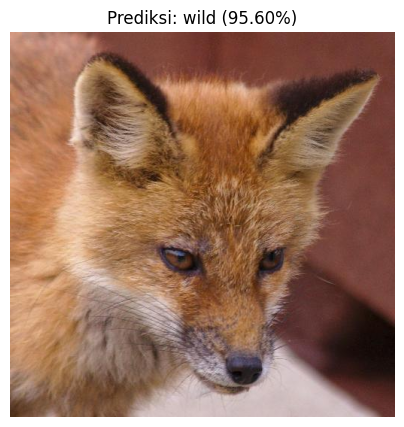

Probabilitas per kelas:
cat: 4.40%
dog: 0.00%
wild: 95.60%


In [25]:
predict_and_show("split_data/test/wild/flickr_wild_000093.jpg", model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


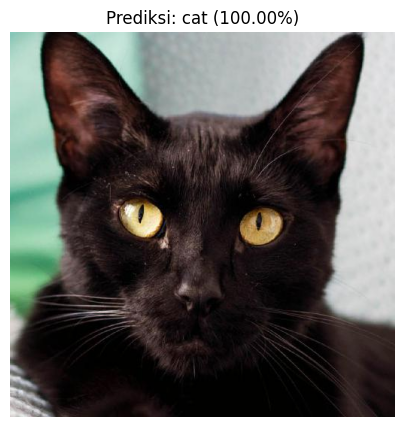

Probabilitas per kelas:
cat: 100.00%
dog: 0.00%
wild: 0.00%


In [27]:
predict_and_show("split_data/test/cat/flickr_cat_000189.jpg", model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


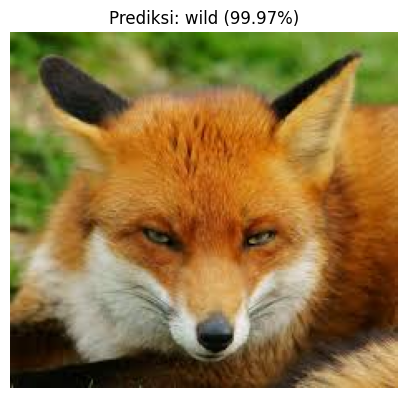

Probabilitas per kelas:
cat: 0.03%
dog: 0.00%
wild: 99.97%


In [38]:
predict_and_show("sampel1.jpeg", model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


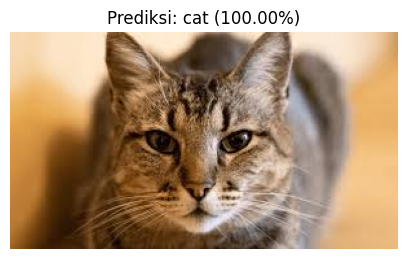

Probabilitas per kelas:
cat: 100.00%
dog: 0.00%
wild: 0.00%


In [35]:
predict_and_show("sampel2.jpeg", model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


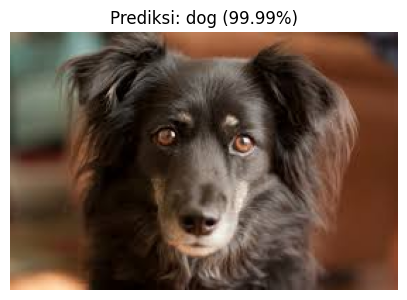

Probabilitas per kelas:
cat: 0.00%
dog: 99.99%
wild: 0.01%


In [37]:
predict_and_show("sampel3.jpeg", model, class_labels)

In [ ]:
import shutil
from google.colab import files

# Membuat file zip berisi seluruh isi direktori (kecuali sample_data)
shutil.make_archive('all_my_files', 'zip', '/content')

# Unduh zip-nya
files.download('all_my_files.zip')